In [1]:
print(1)


1


In [2]:
import ir_datasets
import email
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import re
import numpy as np
import json
import os

from results_config import *

In [3]:
import sys
sys.path.append("scripts/")
from dataset import load_sara
from eval import jupyter_evaluation
from model import llm_experiment, post_process_split_docs
from models import get_model_version
from preprocess_sara import full_preproc, clean


#s = load_sara()
#proc = proccutit(s)
#tokenizer, model = get_model_version('get_mistral', "mistralai/Mistral-7B-Instruct-v0.2", 'main', 'auto')
#jupyter_evaluation(labels, preds)
#llm_experiment(dataset, prompt_strategy, model, tokenizer, end_prompt=None):
#post_process_split_docs(mr, fpr, pre, df)

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
s = load_sara()
processed_emails = [clean(a) for a in s.text]
ids = s.doc_id.tolist()
sens = s.sensitivity.tolist()
texts = [' '.join(processed_emails[i]) for i, text in enumerate(s.text)]
new_dict = {'doc_id': ids, 'text': texts, 'sensitivity':sens}
s = pd.DataFrame.from_dict(new_dict)

In [5]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2", use_fast=True)


#### Reading results

In [6]:
def get_join(doc_ids, preds, gts):
    clean_doc_ids = {}
    for i, idd in enumerate(doc_ids):
        if '_' in idd:
            idd = idd[:idd.find('_')]

        p = preds[i]
        gt = gts[i]
        if p is None:
            p = 1.0
        new_pred = {
            'doc_id': idd,
            'prediction': p,
            'ground_truth': gt,
        }
        if idd not in clean_doc_ids.keys():
            clean_doc_ids[idd] = new_pred
            continue
        if p == 0:
            continue
        clean_doc_ids[idd] = new_pred
    return clean_doc_ids

In [39]:
def new_get_join(data):
    collected_truths = []
    collected_docids = []
    mapp = {}
    for item in data:
        doc_id = item.get('doc_id')
        if '_' in doc_id:
            doc_id = doc_id[:doc_id.find('_')]
        truth = dddd[dddd.doc_id == doc_id].iloc[0].sensitivity
        pred = item.get('prediction')

        if doc_id not in collected_docids:
            if pred is None:
                pred = 1
            collected_docids.append(doc_id)
            collected_truths.append(truth)
            new_pred = {
                'doc_id': doc_id,
                'prediction': pred,
                'ground_truth': truth,
            }
            mapp[doc_id] = new_pred

        if pred == 1:
            new_pred = {
                'doc_id': doc_id,
                'prediction': int(pred),
                'ground_truth': int(truth),
            }
            mapp[doc_id] = new_pred

    mapp = list(mapp.values())
    return pd.DataFrame(mapp)

In [47]:
def get_results_json(mname, clean=True):
    current_directory = os.getcwd()
    #parent_directory = os.path.dirname(current_directory)
    target_directory = os.path.join(current_directory, f'scripts/results/model_results/{mname}/')
    #print("Path to results", target_directory)
    prompt_results = os.listdir(target_directory)
    main_results = []
    for prompt in prompt_results:
        if prompt not in prompts:
            continue
        #prompt = 'base_personal'
        prompt_path = os.path.join(target_directory, prompt)
        file_path = os.path.join(prompt_path, 'all_responses.json')
        #print(file_path)
        with open(file_path) as json_file:
            data = json.load(json_file)
        
        if not clean:
            main_results += data
            continue

        # Clean json to single prediction for document
        #preds = [item.get('prediction') for item in data]
        #gts = [item.get('ground_truth') for item in data]
        #idds = [item.get('doc_id') for item in data]
        #single_preds = get_join(idds, preds, gts)
        #new_preds = list(single_preds.values())
        #clean_json = []
        #for v in new_preds:
        #    clean = v
        #    clean['model'] = mname
        #    clean['prompt'] = prompt
        #    clean_json.append(clean)

        data_df = new_get_join(data)
        clean_json = []
        for i, v in data_df.iterrows():
            clean = {
                'doc_id': v.doc_id,
                'prediction': v.prediction,
                'ground_truth': v.ground_truth,
                'model': mname,
                'prompt': prompt
            }
            clean_json.append(clean)

        main_results += clean_json
    df = pd.DataFrame(main_results)
    return df

In [48]:
all_results_df = get_results_json('mist7b-mist')
gen_results_df = get_results_json('mist7b-mist', clean=False)

In [49]:
all_results_df

,doc_id,prediction,ground_truth,model,prompt
0,175624,0,0,mist7b-mist,context_b2_sens
1,136233,1,0,mist7b-mist,context_b2_sens
2,173279,0,0,mist7b-mist,context_b2_sens
3,175388,0,0,mist7b-mist,context_b2_sens
4,174204,0,0,mist7b-mist,context_b2_sens
...,...,...,...,...,...
20457,9275,1,0,mist7b-mist,multi_category
20458,253094,1,0,mist7b-mist,multi_category
20459,125769,1,0,mist7b-mist,multi_category
20460,125771,1,0,mist7b-mist,multi_category


In [50]:
all_results_df[(all_results_df.prediction!=0) & (all_results_df.prediction!=1)]


,doc_id,prediction,ground_truth,model,prompt


In [108]:
all_results_df

,doc_id,prediction,ground_truth,model,prompt
0,175624,0,0,mist7b-mist,context_b2_sens
1,136233,1,0,mist7b-mist,context_b2_sens
2,173279,0,0,mist7b-mist,context_b2_sens
3,175388,0,0,mist7b-mist,context_b2_sens
4,174204,0,0,mist7b-mist,context_b2_sens
...,...,...,...,...,...
20457,9275,1,0,mist7b-mist,multi_category
20458,253094,1,0,mist7b-mist,multi_category
20459,125769,1,0,mist7b-mist,multi_category
20460,125771,1,0,mist7b-mist,multi_category


In [35]:
y1 = [0, 1, 1, 0]
y2 = [0, 1, 1, 1]

balanced_accuracy_score(y1, y2)

0.75

In [36]:
y1 = all_results_df['prediction'].values
y2 = all_results_df['ground_truth'].values
balanced_accuracy_score(y1, y2)

0.5329036635006784

In [133]:
balanced_accuracy_score(all_results_df['ground_truth'].values, all_results_df['prediction'].values)

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/sklearn/utils/_array_api.py:245: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_pred contains NaN.

In [47]:
all_results_df[(all_results_df.prompt=='base_personal') & (all_results_df.ground_truth==1)]


,doc_id,prediction,ground_truth,model,prompt
17319,54619,1.0,1,mist7b-mist,base_personal
17356,54549,1.0,1,mist7b-mist,base_personal
17363,120289,1.0,1,mist7b-mist,base_personal
17366,54675,1.0,1,mist7b-mist,base_personal
17373,54546,1.0,1,mist7b-mist,base_personal
...,...,...,...,...,...
18796,176571,1.0,1,mist7b-mist,base_personal
18823,9176,1.0,1,mist7b-mist,base_personal
18826,174376,1.0,1,mist7b-mist,base_personal
18859,192801,1.0,1,mist7b-mist,base_personal


In [49]:
s = full_preproc(load_sara(), tokenizer)

In [50]:
s[s.sensitivity == 0]

,doc_id,text,sensitivity
0,114715_0,though i had a somewhat different notion when ...,0
1,114715_1,original message from lee s friedman sent tues...,0
2,229405_0,fyi the attached article and story is disturbi...,0
3,229405_1,original message from lighthill sandra sent we...,0
4,229405_2,original message from castellano bonne sent we...,0
...,...,...,...
3194,175841_0,,0
3195,175841_1,forwarded by steven j kean na enron on pm jeff...,0
3196,175841_2,forwarded by jeff dasovich na enron on am jeff...,0
3197,175841_3,forwarded by jeff dasovich na enron on pm jeff...,0


In [51]:
s[s.sensitivity == 1]


,doc_id,text,sensitivity
62,192801,good plan i agree re sj she is on the ball mh ...,1
150,176675_0,please call me,1
151,176675_1,forwarded by steven j kean na enron on pm from...,1
419,54546_0,,1
420,54546_1,original message from mailto imceanotes enerfa...,1
...,...,...,...
2976,54683_1,original message from joanna vidal sent tuesda...,1
2977,54683_2,original message from to sent tuesday july pm ...,1
2978,54683_3,original message from joanna vidal mailto imce...,1
2979,54683_4,original message from to cc sent tuesday july ...,1


In [9]:
import numpy as np
import pandas as pd
import re
import email
import gensim

import string

def clean(e):
    message = email.message_from_string(e)
    clean = message.get_payload()
    clean = re.sub('\S*@\S*\s?', '', clean)
    clean = re.sub('\s+', ' ', clean)
    clean = re.sub("\'", "", clean)
    clean = gensim.utils.simple_preprocess(str(clean), deacc=True, min_len=1, max_len=100) 
    return clean

def full_preproc(s, tokenizer, c_size=2048):

    def preprocess(e):
        message = email.message_from_string(e)
        clean = message.get_payload()
        clean = re.sub('\S*@\S*\s?', '', clean)
        clean = re.sub('\s+', ' ', clean)
        clean = re.sub("\'", "", clean)
        clean = gensim.utils.simple_preprocess(str(clean), deacc=True, min_len=1, max_len=100) 
        #clean = clean.lower()
        #clean = clean.translate(str.maketrans('','', string.punctuation))
        #clean = clean.translate(str.maketrans('','', "-_?"))
        return clean

    def remove_doubles(df):
        already_exists = []
        unique_df = []
        for i, s in enumerate(df.iterrows()):
            idd = s[1].doc_id
            text = s[1].text
            sensitivity = s[1].sensitivity
            if text in already_exists:
                continue
            already_exists.append(text)
            unique_df.append({'doc_id': idd, 'text':text, 'sensitivity':sensitivity})    
        return pd.DataFrame.from_dict(unique_df)

    def main(s):
        processed_emails = [preprocess(a) for a in s.text]
        ids = s.doc_id.tolist()
        sens = s.sensitivity.tolist()
        texts = []
        for i, text in enumerate(s.text):
            new_email = ' '.join(processed_emails[i])
            texts.append(new_email)

        new_dict = {'doc_id': ids, 'text': texts, 'sensitivity':sens}
        preproc_df = pd.DataFrame.from_dict(new_dict)
        preproc_df = remove_doubles(preproc_df)
        return preproc_df
        places = get_replies(preproc_df)
        new_docs = chunk_large(preproc_df, places, tokenizer, c_size)
        new_docs = pd.DataFrame.from_dict(new_docs)
        return new_docs

    return main(s)

dddd =full_preproc(load_sara(), tokenizer)

In [91]:
dddd[dddd.sensitivity == 1]

,doc_id,text,sensitivity
33,192801,good plan i agree re sj she is on the ball mh ...,1
83,176675,please call me forwarded by steven j kean na e...,1
188,54546,original message from mailto imceanotes enerfa...,1
190,54549,original message from nw security and bug patc...,1
192,54554,martin you may find it useful vince original m...,1
...,...,...,...
1418,54676,original message from huang alex sent tuesday ...,1
1449,54625,original message from gibner stinson sent wedn...,1
1451,54657,greetings from london what do you think about ...,1
1452,54658,original message from bharati rakesh sent frid...,1


In [9]:
all_results_df

,doc_id,prediction,ground_truth,model,prompt
0,175624,0.0,0,mist7b-mist,context_b2_sens
1,136233,1.0,0,mist7b-mist,context_b2_sens
2,173279,0.0,0,mist7b-mist,context_b2_sens
3,175388,0.0,0,mist7b-mist,context_b2_sens
4,174204,0.0,0,mist7b-mist,context_b2_sens
...,...,...,...,...,...
20457,9275,1.0,0,mist7b-mist,multi_category
20458,253094,1.0,0,mist7b-mist,multi_category
20459,125769,1.0,0,mist7b-mist,multi_category
20460,125771,1.0,0,mist7b-mist,multi_category


#### Prompt Effectiveness

Prompt performance: How models perform across different prompts

In [54]:
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score

def calculate_accuracy(group):
    correct_predictions = (group['prediction'] == group['ground_truth']).sum()
    total_predictions = len(group)
    accuracy = correct_predictions / total_predictions
    return accuracy

def calculate_balanced_accuracy(group):
    return balanced_accuracy_score(group['ground_truth'], group['prediction'])

def calculate_f1(group):
    return f1_score(group['ground_truth'], group['prediction'], average='weighted')

def calc_prec(group):
    return precision_score(group['ground_truth'], group['prediction'])

def calc_rec(group):
    return recall_score(group['ground_truth'], group['prediction'])

def prompt_performance(df):
    #accuracy_df = results_df.groupby(['model', 'prompt']).apply(lambda x: (x['prediction'] == x['ground_truth']).mean()).reset_index(name='accuracy')
    # Group by model and prompt, then apply the calculation for each metric
    grouped = df.groupby(['model', 'prompt'])
    accuracy_df = grouped.apply(calculate_accuracy).reset_index(name='accuracy')
    balanced_accuracy_df = grouped.apply(calculate_balanced_accuracy).reset_index(name='balanced_accuracy')
    f1_score_df = grouped.apply(calculate_f1).reset_index(name='f1_score')
    prec_df = grouped.apply(calc_prec).reset_index(name='prec')
    rec_df = grouped.apply(calc_rec).reset_index(name='recall')


    # Merge results into a single DataFrame - easy comparison
    performance_df = pd.merge(accuracy_df, balanced_accuracy_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, f1_score_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, prec_df, on=['model', 'prompt'])
    performance_df = pd.merge(performance_df, rec_df, on=['model', 'prompt'])


    #print(performance_df)
    return performance_df

prompt_performance_df = prompt_performance(all_results_df)

In [55]:
prompt_performance_df = prompt_performance_df

prompt_order = ['base_sens', 'base2_sens', 'context_b1_sens', 'context_b2_sens', 'base_personal', 'context_b1_personal', 'fixed_fewshot_personal', 'base_personal_explanation', 'purely_personal', 'itspersonalgenres', 'multi_category_noanseng', 'multi_category', 'base_classify', 'barlit', 'barlit2']
prompt_performance_df['prompt'] = pd.Categorical(prompt_performance_df['prompt'], categories=prompt_order, ordered=True)
prompt_performance_df = prompt_performance_df.sort_values('prompt')

#print(prompt_performance_df)
prompt_performance_df


,model,prompt,accuracy,balanced_accuracy,f1_score,prec,recall
4,mist7b-mist,base_sens,0.790978,0.482376,0.782043,0.086957,0.071429
0,mist7b-mist,base2_sens,0.526684,0.423336,0.607058,0.084720,0.285714
6,mist7b-mist,context_b1_sens,0.844981,0.495713,0.807449,0.100000,0.030612
7,mist7b-mist,context_b2_sens,0.620076,0.428534,0.677258,0.072340,0.173469
2,mist7b-mist,base_personal,0.524778,0.575420,0.601988,0.156716,0.642857
5,mist7b-mist,context_b1_personal,0.319568,0.530431,0.370935,0.133277,0.811224
8,mist7b-mist,fixed_fewshot_personal,0.279543,0.533830,0.310555,0.133594,0.872449
3,mist7b-mist,base_personal_explanation,0.358958,0.535422,0.423293,0.135426,0.770408
12,mist7b-mist,purely_personal,0.622618,0.596287,0.686324,0.177994,0.561224
9,mist7b-mist,itspersonalgenres,0.756671,0.609390,0.783675,0.232092,0.413265


### Document Difficultly

In [56]:
prompts

['base_sens',
 'base2_sens',
 'context_b1_sens',
 'context_b2_sens',
 'base_personal',
 'context_b1_personal',
 'fixed_fewshot_personal',
 'base_personal_explanation',
 'purely_personal',
 'itspersonalgenres',
 'multi_category_noanseng',
 'multi_category',
 'base_classify']

In [57]:
def get_most_difficult_docs(df):
    misclassification_df = df.groupby('doc_id').apply(lambda x: (x['prediction'] != x['ground_truth']).mean()).reset_index(name='misclassification_rate')
    # Sorting finds the documents with the highest misclassification rates
    return misclassification_df.sort_values(by='misclassification_rate', ascending=False)

def get_all_wrong():
    # Documents entirely misclassified
    return most_difficult_docs[most_difficult_docs.misclassification_rate == 1]

slim = ['base_personal', 'fixed_fewshot_personal', 'purely_personal', 'itspersonalgenres', 'multi_category']
focused_df = all_results_df[all_results_df['prompt'].isin(slim)]
most_difficult_docs = get_most_difficult_docs(focused_df)
all_wrong = get_all_wrong()
#all_wrong = most_difficult_docs[:100]

In [58]:
doc_ids = all_wrong.doc_id.to_list()
filtered_df = s[s['doc_id'].isin(doc_ids)]
print(filtered_df)

'''
for i, row in filtered_df.iterrows():
    print(row.doc_id)
    print(row.text)
    print()
'''

      doc_id                                               text  sensitivity
10     98429  you may have seen this when it first came out ...            0
11    221314  this note is to report on two electricity legi...            0
20    233684  jbennett pm to robert williams e mail richard ...            0
21    221411  jim the quick answer to your question on the b...            0
27    192767  matt as gss business development transitions t...            0
...      ...                                                ...          ...
1612  174417  looks good mark palmer pm to steven j cc subje...            0
1628  175314  minor changes shown on the attached gotta get ...            0
1634  175360  i forgot to email myself the brief to track ch...            0
1690  173252  fyi forwarded by steven j kean hou ees on pm j...            0
1701  175841  forwarded by steven j kean na enron on pm jeff...            0

[273 rows x 3 columns]


'\nfor i, row in filtered_df.iterrows():\n    print(row.doc_id)\n    print(row.text)\n    print()\n'

In [59]:
print(len(filtered_df))
proc_filtered_df = full_preproc(filtered_df, tokenizer)
print(len(proc_filtered_df))

273
273


In [60]:
doc_lengths = s.text.str.len()
print(sorted(doc_lengths.values, reverse=True))

[207061, 190116, 190116, 171851, 171851, 169371, 169371, 151783, 151783, 151783, 131958, 131958, 127632, 127632, 127632, 127632, 127632, 127632, 113765, 113765, 112401, 112401, 110186, 110186, 110186, 110186, 110186, 110186, 110186, 104395, 104395, 104395, 104395, 104395, 100077, 100077, 100077, 90210, 90210, 90210, 85611, 85611, 81297, 78496, 78496, 78496, 78496, 78496, 67419, 67419, 67419, 67419, 67419, 62917, 62917, 62541, 61299, 61299, 59862, 59862, 59862, 59862, 59862, 56536, 51431, 45835, 43595, 39742, 31633, 31441, 30067, 30059, 29885, 28093, 27194, 23322, 21475, 21318, 21194, 20554, 20532, 20478, 20372, 20290, 20240, 20195, 15262, 14253, 14130, 13424, 13293, 13293, 13049, 12552, 12377, 12321, 12305, 11384, 11113, 11111, 10952, 10761, 10563, 10351, 10327, 10266, 10074, 9860, 9205, 9205, 8986, 8639, 8393, 8350, 8249, 8090, 8070, 8045, 7952, 7801, 7787, 7766, 7568, 7499, 7305, 7300, 7244, 7164, 7155, 7154, 7119, 7118, 7097, 7056, 6985, 6937, 6585, 6574, 6435, 6384, 6347, 6346, 628

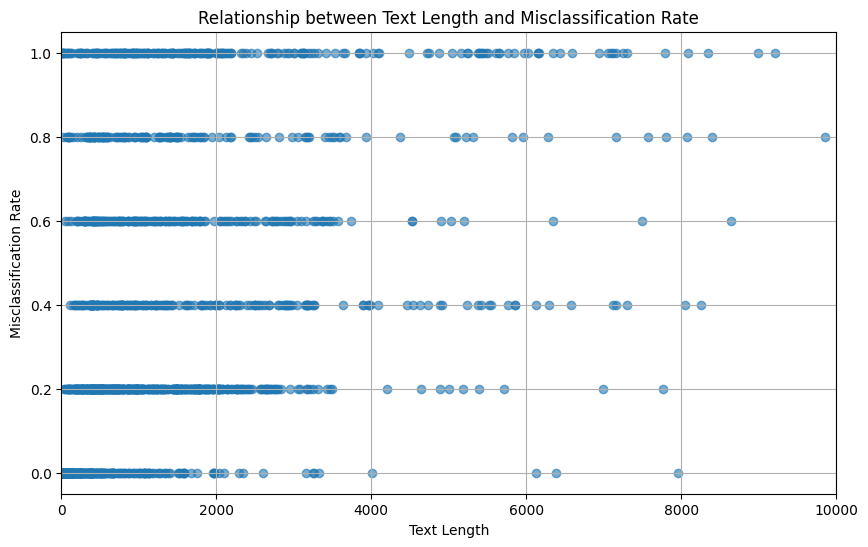

In [61]:
pdf = pd.merge(s, most_difficult_docs, on=['doc_id'])
pdf
df = pdf
df['text_length'] = df['text'].apply(len)

# Plotting the relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['text_length'], df['misclassification_rate'], alpha=0.6)
plt.title('Relationship between Text Length and Misclassification Rate')
plt.xlabel('Text Length')
plt.ylabel('Misclassification Rate')
plt.grid(True)
plt.xlim(0, 10000)
plt.show()

Statistical Testing

<Figure size 500x500 with 0 Axes>

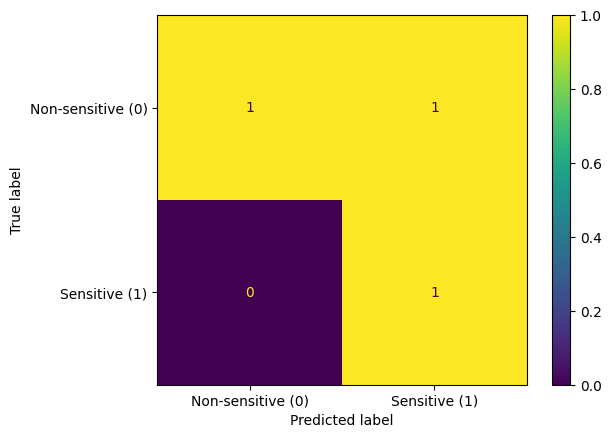

In [86]:
def evaluation_summary(true_labels, predictions):
    target_labels = [0, 1]
    target_classes = ['Non-sensitive (0)', 'Sensitive (1)']
    report = classification_report(true_labels, predictions, labels=target_labels, target_names=target_classes, digits=3, zero_division=0)
    #print(report)
    confusionMatrix = confusion_matrix(true_labels, predictions, labels=target_labels)
    fig = plt.figure(1, figsize=(5, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=target_classes)
    disp.plot()
    #disp.figure_.savefig(description+"confusion_matrix.pdf")
    plt.show()
    return disp

evaluation_summary([1,0,0], [1,0,1])

<Figure size 500x500 with 0 Axes>

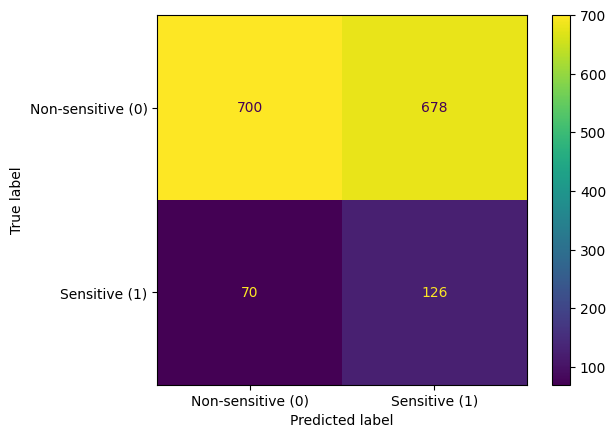

<Figure size 500x500 with 0 Axes>

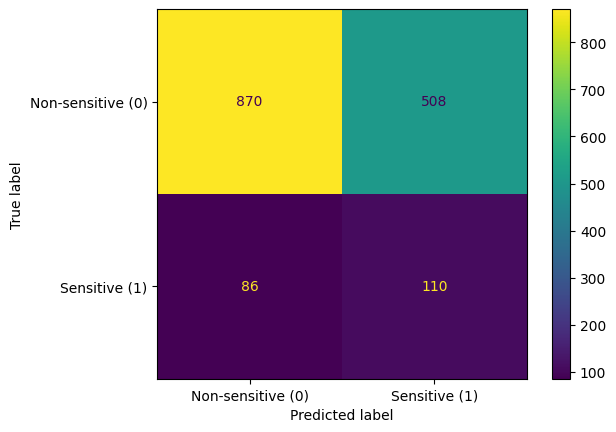

<Figure size 500x500 with 0 Axes>

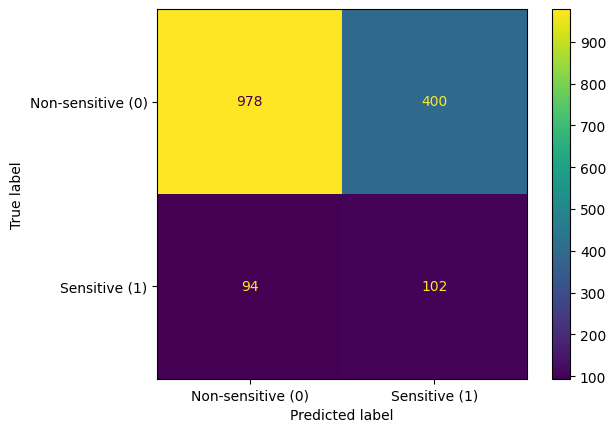

<Figure size 500x500 with 0 Axes>

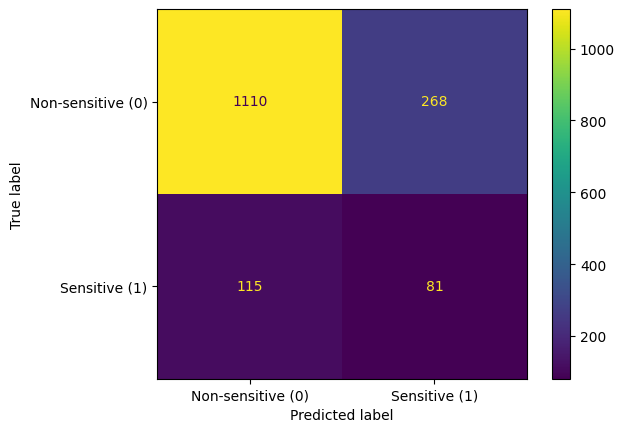

In [107]:
p = all_results_df[all_results_df.prompt == 'base_personal'].prediction.to_list()
t = all_results_df[all_results_df.prompt == 'base_personal'].ground_truth.to_list()

evaluation_summary(t, p)

p = all_results_df[all_results_df.prompt == 'purely_personal'].prediction.to_list()
t = all_results_df[all_results_df.prompt == 'purely_personal'].ground_truth.to_list()

evaluation_summary(t, p)

p = all_results_df[all_results_df.prompt == 'multi_category'].prediction.to_list()
t = all_results_df[all_results_df.prompt == 'multi_category'].ground_truth.to_list()

evaluation_summary(t, p)

p = all_results_df[all_results_df.prompt == 'itspersonalgenres'].prediction.to_list()
t = all_results_df[all_results_df.prompt == 'itspersonalgenres'].ground_truth.to_list()
evaluation_summary(t, p)


In [105]:
focused_df.prompt.unique()

array(['fixed_fewshot_personal', 'itspersonalgenres', 'purely_personal',
       'base_personal', 'multi_category'], dtype=object)

In [63]:
from statsmodels.stats.contingency_tables import mcnemar

# Example predictions
# Let's assume 0 for incorrect predictions and 1 for correct predictions
model1_predictions = [1, 0, 1, 1, 0, 1, 0, 1]
model2_predictions = [1, 1, 1, 0, 0, 0, 1, 0]

# Building the contingency table
contingency_table = [[0, 0], [0, 0]]

for pred1, pred2 in zip(model1_predictions, model2_predictions):
    contingency_table[pred1][pred2] += 1

contingency_table

[[1, 2], [3, 2]]

In [103]:
from statsmodels.stats.contingency_tables import mcnemar

def run_mcnemar(table):
    result = mcnemar(table, exact=True, correction=True)
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    alpha = 0.05
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

def mcnemar_table(control, change):
    '''
    BOTH_COR    CONTROL_COR
    CHANGE_COR  BOTH_WRONG
    '''
    all_ids = control.doc_id.tolist()
    control = control[control['prediction'] == control['ground_truth']].doc_id.to_list()
    change = change[change['prediction'] == change['ground_truth']].doc_id.to_list()

    seen_id = []
    both_correct = 0
    control_cor = 0
    change_cor = 0
    both_incor = 0

    for val in control:
        if val in change:
            both_correct += 1
        else:
            control_cor += 1
        seen_id.append(val)

    for val in change:
        if val in seen_id:
            continue
        else:
            change_cor += 1
        seen_id.append(val)

    
    both_incor = len(all_ids) - (both_correct + control_cor + change_cor)
    table = [[both_correct, control_cor], [change_cor, both_incor]]
    return table

def mcnemar_table(control, change):
    control = control.sort_values(by='doc_id')
    change = change.sort_values(by='doc_id')
    model1_predictions = control.prediction.to_list()
    model2_predictions = change.prediction.to_list()

    model1_predictions = [0 if pred == truth else 1 for pred, truth in zip(model1_predictions, control.ground_truth.to_list())]
    model2_predictions = [0 if pred == truth else 1 for pred, truth in zip(model2_predictions, change.ground_truth.to_list())]

    contingency_table = [[0, 0], [0, 0]]
    for pred1, pred2 in zip(model1_predictions, model2_predictions):
        contingency_table[int(pred1)][int(pred2)] += 1

    return contingency_table


def mc_eval_util_prompt(results_df, prompt_name, prompt_name2):
    orig = results_df[results_df.prompt == prompt_name]
    pure = results_df[results_df.prompt == prompt_name2]
    table = mcnemar_table(orig, pure)
    return table

def mc_eval_util_model(results_df, model_name, model_name2):
    orig = results_df[results_df.model == model_name]
    pure = results_df[results_df.model == model_name2]
    table = mcnemar_table(orig, pure)
    return table

def mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, df):
    if (model_name != model_name2) and (prompt_name != prompt_name2):
        print('Multiple difference')
        return []
    
    if prompt_name != prompt_name2:
        results_df = df[(df.model == model_name)]
        overall_table = mc_eval_util_prompt(results_df, prompt_name, prompt_name2)
        non_results_df = results_df[results_df['ground_truth'] == 0]
        non_table = mc_eval_util_prompt(non_results_df, prompt_name, prompt_name2)
        sen_results_df = results_df[results_df['ground_truth'] == 1]
        sen_table = mc_eval_util_prompt(sen_results_df, prompt_name, prompt_name2)
    else:
        results_df = df[(df.prompt == prompt_name)]
        overall_table = mc_eval_util_model(results_df, model_name, model_name2)
        non_results_df = results_df[results_df['ground_truth'] == 0]
        non_table = mc_eval_util_model(non_results_df, model_name, model_name2)
        sen_results_df = results_df[results_df['ground_truth'] == 1]
        sen_table = mc_eval_util_model(sen_results_df, model_name, model_name2)

    print('Overall\t\t Non-sensitive only\t Sensitive only')
    #print(np.matrix(overall_table), end='')
    #print(np.matrix(non_table), end='')

    print(np.matrix(overall_table[0]), '\t', np.matrix(non_table[0]), '\t\t', np.matrix(sen_table[0]))
    print(np.matrix(overall_table[1]), '\t', np.matrix(non_table[1]), '\t\t', np.matrix(sen_table[1]))
    return overall_table


model_name = 'mist7b-mist'
model_name2 = 'mist7b-mist'

compare = [('base_personal','purely_personal'), ('base_personal', 'multi_category')]
for v in compare:
    print("""Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    """)
    print('Control:', v[0], '\tChange:', v[1])
    prompt_name = v[0]
    prompt_name2 = v[1]
    overall = mcnemar_eval(model_name, model_name2, prompt_name, prompt_name2, focused_df)
    run_mcnemar(overall)


Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    
Control: base_personal 	Change: purely_personal
Overall		 Non-sensitive only	 Sensitive only
[[769  57]] 	 [[665  35]] 		 [[104  22]]
[[211 537]] 	 [[205 473]] 		 [[ 6 64]]
statistic=57.000, p-value=0.000
Different proportions of errors (reject H0)
Mcnemar's where,
                        Condition 2 Positive	    Condition 2 Negative
Condition 1 Positive	A (Positive at both times)	B (Positive then Negative)
Condition 1 Negative	C (Negative then Positive)	D (Negative at both times)
    
Control: base_personal 	Change: multi_category
Overall		 Non-sensitive only	 Sensitive only
[[798  28]] 	 [[698   2]] 		 [[100  26]]
[[282 466]] 	 [[280 398]] 		 [[ 2 68]]
statistic=28.000, p-value=0.000
Different proportions of errors (reject H0)


In [32]:
focused_df[(focused_df.prompt=='base_personal') & (focused_df.ground_truth==0)]

,doc_id,prediction,ground_truth,model,prompt
17314,175624,1.0,0,mist7b-mist,base_personal
17315,136233,0.0,0,mist7b-mist,base_personal
17316,173279,1.0,0,mist7b-mist,base_personal
17317,175388,0.0,0,mist7b-mist,base_personal
17318,174204,0.0,0,mist7b-mist,base_personal
...,...,...,...,...,...
18883,122671,1.0,0,mist7b-mist,base_personal
18884,121104,1.0,0,mist7b-mist,base_personal
18885,174641,1.0,0,mist7b-mist,base_personal
18886,176772,1.0,0,mist7b-mist,base_personal


In [33]:
focused_df[(focused_df.prompt=='fixed_fewshot_personal') & (focused_df.ground_truth==0)]


,doc_id,prediction,ground_truth,model,prompt
1574,54584,0.0,0,mist7b-mist,fixed_fewshot_personal
1575,121036,1.0,0,mist7b-mist,fixed_fewshot_personal
1576,174345,1.0,0,mist7b-mist,fixed_fewshot_personal
1577,177822,1.0,0,mist7b-mist,fixed_fewshot_personal
1578,175353,1.0,0,mist7b-mist,fixed_fewshot_personal
...,...,...,...,...,...
3143,9275,1.0,0,mist7b-mist,fixed_fewshot_personal
3144,253094,1.0,0,mist7b-mist,fixed_fewshot_personal
3145,125769,1.0,0,mist7b-mist,fixed_fewshot_personal
3146,125771,1.0,0,mist7b-mist,fixed_fewshot_personal


,doc_id,text,sensitivity
0,114715,though i had a somewhat different notion when ...,0
1,229405,fyi the attached article and story is disturbi...,0
2,232795,forwarded by richard b sanders hou ect on am s...,0
3,62815,louise lisa yoho suggested i forward the attac...,0
4,118871,forwarded by jeff dasovich na enron on am susa...,0
...,...,...,...
1697,232322,forwarded by richard b sanders hou ect on pm c...,0
1698,175448,forwarded by steven j kean na enron on pm on p...,0
1699,175814,forwarded by steven j kean na enron on pm sent...,0
1700,175816,test forwarded by steven j kean na enron on am...,0


In [43]:
x = focused_df[(focused_df.prompt=='base_personal') & (focused_df.ground_truth==0)].doc_id.to_list()
y = focused_df[(focused_df.prompt=='fixed_fewshot_personal') & (focused_df.ground_truth==0)].doc_id.to_list()
for val in x:
    tru = s[s.doc_id == val].sensitivity
    #print(tru.iloc[0])
    if tru.iloc[0] != 0:
        print(val)

54626
54616
54615
176539
54614
54643
54644
54646
54676
54677
54612
54658
175500
54625
175499
54562
175596
175493
149993
54846
174123
121748
175140
54636
119214
176675
174212
54566
173801
54674
54567
54655
175810
173412
54540
54537
54669
229326
54554
54671
54552
54573
54630
54544
54588
175209
54555
175222
174265
54660
54656
54657
192771
54603
54592
54664
54580
173803
54645
165052
173884
54668
54662
175309
54583
175418
65969
54578
173954
54263
54575
175163
54606
54632
52713
54593
122913
122926
54596
54576
173408
130135
177853
176727
55210
176609
175162
175595
173904
174137
118675
176665
194901
176572
175318
54604
239959
175364
52201
175240
121756
175076
